# Grouping Similar Websites
Similarweb’s first metric was finding similarity between websites. This feature allows businesses to find their online competition, and thus compare their respective internet traffic metrics to gauge their relative success. In this exercise you will be asked to come up with a measure of similarity given a certain precomputed embedding for each website, and use that measure to group websites together.

## Provided Input
The input provided is a precomputed embedding for each website, which is generated as an intermediate of one of our proprietary algorithms. The columns are the name of the website and 24 additional numerical attributes that project the website into a latent semantic space. Note that there is no label in this exercise to refer to as a target.

## Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples

In this dataset you will find a sample of websites paired with their embedded represenations

In [2]:
# File location and type
file_location = './sites_embedding.csv'
data = pd.read_csv(file_location)
data.head()

,site,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,...,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24
0,redditmlbstreams.live,0.00065,0.047358,0.000415,0.000000,0.020111,0.000666,0.000000,0.000000,0.112471,...,0.0,0.000000,0.001137,0.001781,0.003503,0.000000,0.000874,0.784522,0.003230,0.000270
1,ladysavings.com,0.00000,0.001403,0.002369,0.001033,0.000727,0.291403,0.001046,0.629109,0.001919,...,0.0,0.000000,0.012859,0.002759,0.002011,0.000000,0.000193,0.000000,0.002875,0.000000
2,petcarerx.com,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000157,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.999504,0.000000,0.000066,0.000274,0.000000,0.000000
3,govx.com,0.00000,0.006618,0.020445,0.000000,0.003382,0.023401,0.016749,0.013367,0.004601,...,0.0,0.026822,0.030462,0.001754,0.003209,0.007286,0.004858,0.709723,0.028343,0.017201
4,texassports.com,0.00000,0.000292,0.000000,0.000000,0.000000,0.000421,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.004519,0.000000,0.000000,0.066434,0.928334,0.000000,0.000000


## Auxiliary Functions

In [3]:
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary['Missing'] = df.isnull().sum().values
    summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
    summary['Uniques'] = df.nunique().values
    summary['Data type'] = df.dtypes.values
    summary = summary.merge(df.describe().transpose().reset_index(), on = "index",how="left")

    return summary

def jaccard_similarity_continuous_rows_df(df, idx1, idx2):
    """
    Compute the Jaccard similarity coefficient for continuous data between two rows in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    idx1 (int): Index of the first row.
    idx2 (int): Index of the second row.

    Returns:
    float: Jaccard similarity coefficient.
    """
    import numpy as np

    # Extract the values of the two rows
    x = df.iloc[idx1].values
    y = df.iloc[idx2].values

    # Calculate intersection and union
    intersection = np.minimum(x, y).sum()
    union = np.maximum(x, y).sum()

    # Return Jaccard similarity coefficient
    return intersection / union if union != 0 else 0

def analyze_web_similarity(df, n_similar=5, standardize=False):
    """
    Analyzuje podobnost webových stránek na základě jejich features.
    
    # Provedení analýzy
    results = analyze_web_similarity(df)

    # Vizualizace výsledků
    visualize_similarities(results)
    
    Parameters:
    df: DataFrame s názvy webů v prvním sloupci a features v dalších sloupcích
    n_similar: Počet podobných stránek k zobrazení pro každou stránku
    
    Returns:
    dict: Slovník s různými metrikami podobnosti a analýzami
    """
    # Oddělení názvů a features
    websites = df.iloc[:, 0]
    features = df.iloc[:, 1:]
    
    # # Standardizace features
    if standardize:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
    else:
        features_scaled = features
    
    # 1. Kosinová podobnost
    cosine_sim = cosine_similarity(features_scaled)
    
    # 2. Euklidovská vzdálenost
    euclidean_dist = squareform(pdist(features_scaled, 'euclidean'))
    
    # Vytvoření dictionary pro každou webovou stránku s jejími nejpodobnějšími protějšky
    similarity_dict = {}
    for i, website in enumerate(websites):
        # Najdeme nejpodobnější stránky (kromě sebe sama)
        similar_indices = cosine_sim[i].argsort()[::-1][1:n_similar+1]
        similar_websites = [
            {
                'web': websites.iloc[idx],
                'cosine_similarity': cosine_sim[i][idx],
                'euclidean_distance': euclidean_dist[i][idx],
                "jaccard_sim" : jaccard_similarity_continuous_rows_df(features, i, idx)
            }
            for idx in similar_indices
        ]
        similarity_dict[website] = similar_websites
    
    # Základní statistiky features
    feature_stats = {
        'correlation_matrix': features.corr(),
        'feature_importance': np.std(features_scaled, axis=0),
        'feature_names': features.columns
    }
    
    return {
        'similarity_dict': similarity_dict,
        'cosine_similarity_matrix': cosine_sim,
        'euclidean_distance_matrix': euclidean_dist,
        'feature_stats': feature_stats
    }

def visualize_similarities(analysis_results, n_clusters=10):
    """
    Vizualizuje výsledky analýzy podobnosti.
    """
    # Vytvoření heat mapy korelací features
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        analysis_results['feature_stats']['correlation_matrix'],
        cmap='coolwarm',
        center=0,
        annot=False
    )
    plt.title('Korelační matice features')
    plt.tight_layout()
    
    # Vytvoření grafu důležitosti features
    plt.figure(figsize=(12, 6))
    feature_importance = pd.Series(
        analysis_results['feature_stats']['feature_importance'],
        index=analysis_results['feature_stats']['feature_names']
    )
    feature_importance.sort_values(ascending=True).plot(kind='barh')
    plt.title('Důležitost jednotlivých features')
    plt.xlabel('Standardizovaná směrodatná odchylka')
    plt.tight_layout()


In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

class WordEmbeddingClustering:
    """
    A class for clustering word embeddings from a pandas DataFrame where
    the first column contains the words.
    """

    def __init__(self, embedding_df: pd.DataFrame):
        """
        Initialize with the embedding DataFrame.

        Parameters:
        -----------
        embedding_df : pd.DataFrame
            DataFrame where the first column is the word and the remaining columns are embedding dimensions.
        """
        self.embedding_df = embedding_df
        self.words = embedding_df.iloc[:, 0].tolist()
        self.embeddings = embedding_df.iloc[:, 1:].values
        self.normalized_embeddings = self.embeddings
        self.labels_ = None
        self.model = None

    def cluster_embeddings(self, method: str = 'kmeans', n_clusters: int = 10, **kwargs):
        """
        Perform clustering on the normalized embeddings.

        Parameters:
        -----------
        method : str
            Clustering algorithm ('kmeans', 'dbscan', or 'gmm').
        n_clusters : int
            Number of clusters (used for 'kmeans' and 'gmm').
        """
        if method == 'kmeans':
            self.model = KMeans(n_clusters=n_clusters, **kwargs)
        elif method == 'dbscan':
            self.model = DBSCAN(**kwargs)
        elif method == 'gmm':
            self.model = GaussianMixture(n_components=n_clusters, **kwargs)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        self.labels_ = self.model.fit_predict(self.normalized_embeddings)
        self.labels_series = pd.Series(self.labels_, index=self.words, name='cluster')

    def get_cluster_words(self, n_words_per_cluster: int = 5):
        """
        Get representative words for each cluster.

        Parameters:
        -----------
        n_words_per_cluster : int
            Number of words per cluster to return.

        Returns:
        --------
        Dict[int, pd.DataFrame]
            Mapping of cluster labels to DataFrames of representative words.
        """
        if self.labels_ is None:
            raise ValueError("Clustering has not been performed yet.")
        
        cluster_words = {}
        unique_labels = np.unique(self.labels_)
        
        for label in unique_labels:
            if label == -1:
                continue  # Skip noise points
            cluster_indices = np.where(self.labels_ == label)[0]
            cluster_embeddings = self.embeddings[cluster_indices]
            cluster_words_list = [self.words[idx] for idx in cluster_indices]
            cluster_df = pd.DataFrame(cluster_embeddings, index=cluster_words_list)

            if hasattr(self.model, 'cluster_centers_'):
                center = self.model.cluster_centers_[label]
            elif hasattr(self.model, 'means_'):
                center = self.model.means_[label]
            else:
                center = cluster_embeddings.mean(axis=0)
            
            distances = np.linalg.norm(cluster_embeddings - center, axis=1)
            closest_indices = np.argsort(distances)[:n_words_per_cluster]
            representative_words = cluster_df.iloc[closest_indices]
            cluster_words[label] = representative_words
            
        return cluster_words

    def get_cluster_statistics(self):
        """
        Calculate basic statistics for each cluster.

        Returns:
        --------
        pd.DataFrame
            DataFrame with cluster statistics.
        """
        if self.labels_ is None:
            raise ValueError("Clustering has not been performed yet.")
        
        stats = []
        unique_labels = np.unique(self.labels_)
        
        for label in unique_labels:
            if label == -1:
                continue
            cluster_size = np.sum(self.labels_ == label)
            stats.append({
                'cluster': label,
                'size': cluster_size
            })
        
        return pd.DataFrame(stats).set_index('cluster')

    def evaluate_clustering(self):
        """
        Evaluate clustering using Silhouette Score and Davies-Bouldin Index,
        and provide per-cluster silhouette scores.

        Returns:
        --------
        Dict[str, Any]
            Dictionary with evaluation metrics, including per-cluster silhouette scores.
        """
        if self.labels_ is None:
            raise ValueError("Clustering has not been performed yet.")
        
        unique_labels = np.unique(self.labels_)
        if len(unique_labels) > 1:
            # Compute silhouette scores for all samples
            sample_silhouette_values = silhouette_samples(self.normalized_embeddings, self.labels_)
            # Overall silhouette score
            sil_score = sample_silhouette_values.mean()
            # Per-cluster silhouette scores
            cluster_silhouette_scores = {}
            for label in unique_labels:
                if label == -1:  # Skip noise points if using DBSCAN
                    continue
                cluster_mask = self.labels_ == label
                cluster_silhouette = sample_silhouette_values[cluster_mask].mean()
                cluster_silhouette_scores[label] = cluster_silhouette
            # Davies-Bouldin Index
            db_score = davies_bouldin_score(self.normalized_embeddings, self.labels_)
        else:
            sil_score = 0.0
            db_score = 0.0
            cluster_silhouette_scores = {label: 0.0 for label in unique_labels}
        
        return {
            'silhouette_score': sil_score,
            'davies_bouldin_index': db_score,
            'cluster_silhouette_scores': cluster_silhouette_scores
        }
    
    def find_optimal_clusters(self, k_range):
        from sklearn.metrics import silhouette_score, davies_bouldin_score

        wcss = []
        silhouette_scores = []
        db_scores = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.normalized_embeddings)
            wcss.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(self.normalized_embeddings, labels))
            db_scores.append(davies_bouldin_score(self.normalized_embeddings, labels))
        
        metrics = {
            'k_values': list(k_range),
            'wcss': wcss,
            'silhouette_scores': silhouette_scores,
            'davies_bouldin_scores': db_scores
        }
        return metrics

    def plot_k_distance(self, k=5):
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(self.normalized_embeddings)
        distances, indices = neighbors_fit.kneighbors(self.normalized_embeddings)
        distances = np.sort(distances[:, k-1], axis=0)
        plt.figure(figsize=(8, 5))
        plt.plot(distances)
        plt.xlabel('Data Points sorted by distance')
        plt.ylabel(f'{k}th Nearest Neighbor Distance')
        plt.title('Elbow Method For Optimal eps')
        plt.show()

## Part 1
Exploratory data analysis - please describe the embedded features space.

What can you say about the distribution the features? Can you identify any patterns?

(Please support your claims with relevant plots and images)

In [5]:
##### -------- answer goes here (add as many cells as you need) --------- ########

## Part 2
Please identify groups of similar sites.
* How many groups of similar websites can you find? 
* When looking at the content of each group, does your results make sense? can you give names to the groups that you identify?
(Please support your claims with relevant plots and images)

In [6]:
##### -------- answer goes here (add as many cells as you need) --------- ########

Check the data types and missing values.

## Data Exploration and Transformation

In [7]:
summary_data = description(data)
summary_data

Dataset Shape: (4298, 25)


,index,dtypes,Name,Missing,PercMissing,Uniques,Data type,count,mean,std,min,25%,50%,75%,max
0,site,object,site,0,0.0,4298,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F_1,float64,F_1,0,0.0,1190,float64,4298.0,0.001787,0.010403,0.0,0.000000,0.000000,0.000484,0.247244
2,F_2,float64,F_2,0,0.0,3514,float64,4298.0,0.020845,0.045671,0.0,0.000439,0.002788,0.016877,0.447237
3,F_3,float64,F_3,0,0.0,3190,float64,4298.0,0.017037,0.036319,0.0,0.000257,0.004059,0.017894,0.416490
4,F_4,float64,F_4,0,0.0,2198,float64,4298.0,0.006648,0.022044,0.0,0.000000,0.000682,0.005008,0.363324
5,F_5,float64,F_5,0,0.0,3758,float64,4298.0,0.016894,0.038871,0.0,0.000684,0.003770,0.014373,0.431599
6,F_6,float64,F_6,0,0.0,3333,float64,4298.0,0.019237,0.039213,0.0,0.000687,0.004130,0.018647,0.388256
7,F_7,float64,F_7,0,0.0,3081,float64,4298.0,0.088167,0.241905,0.0,0.000000,0.003375,0.017078,0.997308
8,F_8,float64,F_8,0,0.0,2778,float64,4298.0,0.154643,0.326244,0.0,0.000000,0.002394,0.027056,1.000000
9,F_9,float64,F_9,0,0.0,1404,float64,4298.0,0.009034,0.035238,0.0,0.000000,0.000000,0.002758,0.481241


Data values are between 0 and 1, no missings, apparently continuous, all is float. 

Check the distribution of data. I will plot one chart only, other features are similar.

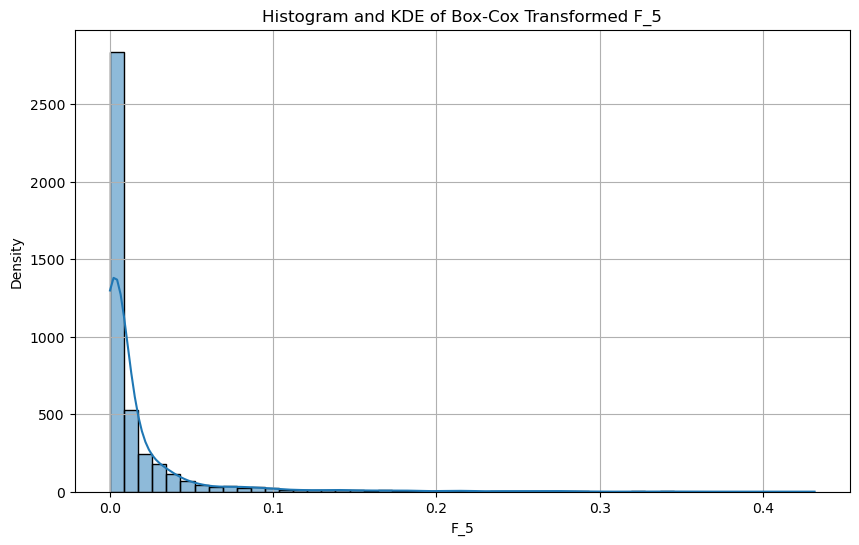

In [8]:
col = "F_5"
plt.figure(figsize=(10, 6))
sns.histplot(data[col], bins=50, kde=True)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Histogram and KDE of Box-Cox Transformed ' + col)
plt.grid(True)
plt.show()

Data are skewed, with some outliers. I will transform them using box cox.

In [9]:
data_tranformed = data.copy()
for col in data.columns[1:]:
    data_tranformed[col + "_transformed"], fitted_lambda = stats.boxcox(data_tranformed[col] + 1)
    # print(f"Column {col} transformed with lambda {fitted_lambda}")

data_tranformed = data_tranformed.drop(columns=data.columns[1:25])

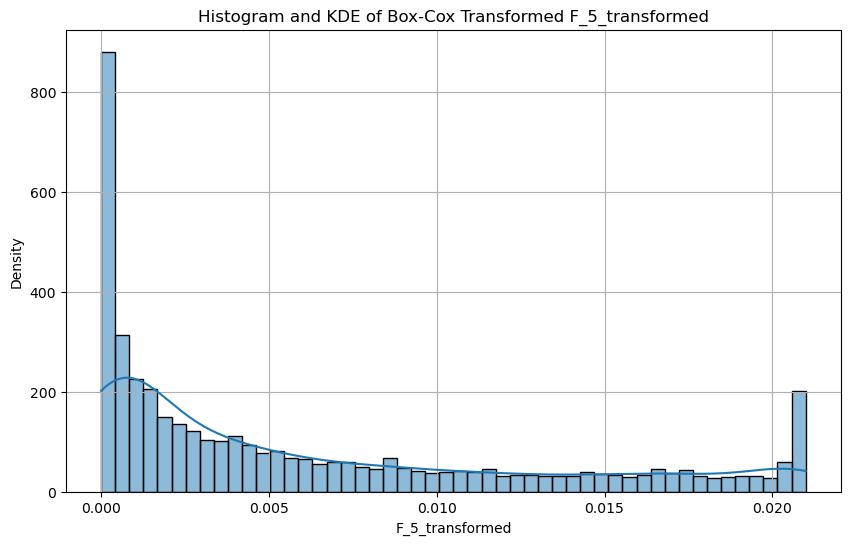

In [10]:
col = "F_5_transformed"
plt.figure(figsize=(10, 6))
sns.histplot(data_tranformed[col], bins=50, kde=True)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Histogram and KDE of Box-Cox Transformed ' + col)
plt.grid(True)
plt.show()

There is a lot of values equal to 0. It seems to me that those were originally missing values and replaced by 0. Check the distribution without 0 values.

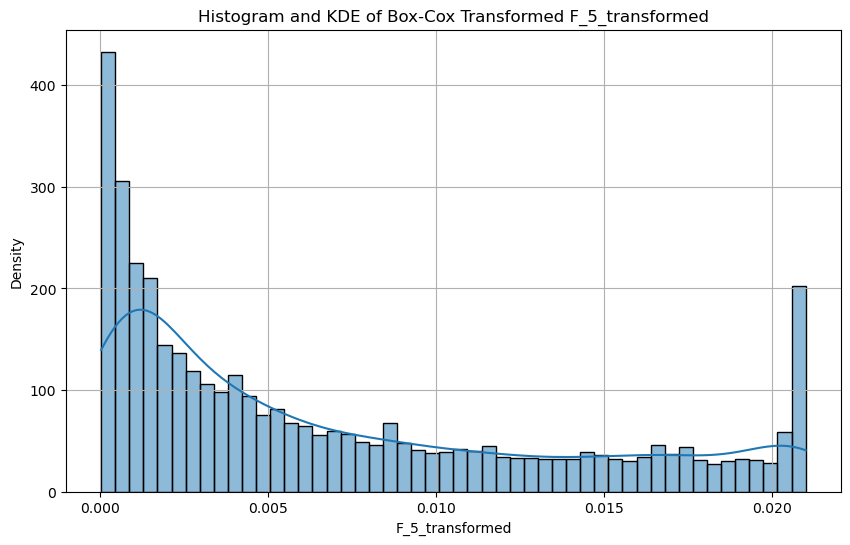

In [11]:
col = "F_5_transformed"
plt.figure(figsize=(10, 6))
sns.histplot(data_tranformed[col].loc[data_tranformed[col] > 0], bins=50, kde=True)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Histogram and KDE of Box-Cox Transformed ' + col)
plt.grid(True)
plt.show()

At first, I thought that the features of the data are some metadata of websites, like number of visits, number of pages, etc. So, naturally, I thought that you took those metadata and normalized them. So, I spent some time trying to find out what those features are. I assumed that if there are number of visits and time spend on the website, they should be somehow correlated or stand out, like "F_8" and "F_10".

<Axes: xlabel='Name'>

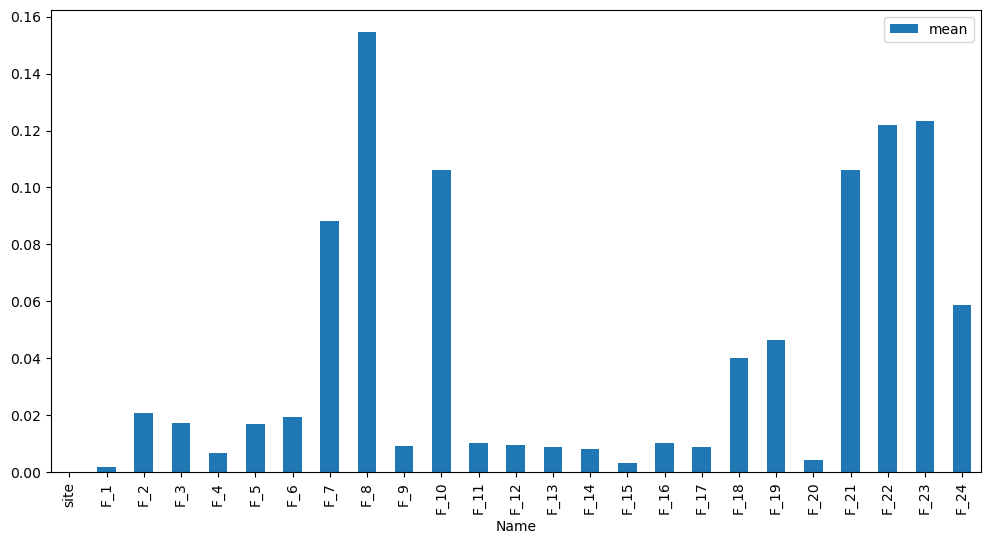

In [12]:
summary_data.plot(x='Name', y='mean', kind='bar', figsize=(12, 6))

## First shot to find meanings of features

However, then I thought that maybe those features are some kind of embeddings. Like: "is the website about sport or news"? And the value would be some measure of how much the website is about sport or news. So, I checked the upper quantiles to see what websites are about.

In [13]:
cols_features = pd.DataFrame()

for col in data_tranformed.columns[1:]:
    col_head = (
        data_tranformed[
            data_tranformed[col] >= data_tranformed[col].quantile(0.99)]
            # .sort_values(by=col, ascending=False)
            .head(20)
            .reset_index(drop=True)
    )["site"]
    cols_features = pd.concat([cols_features, pd.DataFrame({col : col_head})], axis=1)

cols_features

,F_1_transformed,F_2_transformed,F_3_transformed,F_4_transformed,F_5_transformed,F_6_transformed,F_7_transformed,F_8_transformed,F_9_transformed,F_10_transformed,...,F_15_transformed,F_16_transformed,F_17_transformed,F_18_transformed,F_19_transformed,F_20_transformed,F_21_transformed,F_22_transformed,F_23_transformed,F_24_transformed
0,i.imgur.com,npr.org,hotschedules.com,cchs.instructure.com,unrealengine.com,ladysavings.com,citizensbank.com,applebees.com,methstreams.me,wow-professions.com,...,sso.compassmanager.com,redstate.com,sellwellday.site,edition.cnn.com,petcarerx.com,leaffilterguards.com,coursehero.com,wtatennis.com,boards.cruisecritic.com,caredge.com
1,play.stmath.com,fark.com,rsa.choiceadvantage.com,byui.instructure.com,random.org,new.aldi.us,morningstar.com,theforkedspoon.com,vertvenvivo.net,mmo-champion.com,...,360.smg.com,upgrade.plusgrade.com,preferencecenter.hearstmags.com,miamiherald.com,forum.chronofhorse.com,cchs.instructure.com,apply.commonapp.org,nesn.com,oyster.com,quadratec.com
2,newgrounds.com,goodreads.com,login.vmcloudpms.com,trivia.greatergood.com,i.imgur.com,valpak.com,servicemessages.fidelity.com,foodandwine.com,racing.ustrotting.com,speedrun.com,...,secure06ea.chase.com,ftb.ca.gov,mc.beveragepromo.com,stltoday.com,zoetisus.com,link.springer.com,tpi.pearsoncmg.com,clevelandbrowns.com,swiss.com,clublexus.com
3,passes.com,nextmindtech.com,centraldispatch.com,thebreastcancersite.greatergood.com,verizon.com,lasvegas.craigslist.org,ibx.key.com,kitchensanctuary.com,1stream.me,warframe.fandom.com,...,applitrack.com,infowars.com,newport-pleasure.com,ajc.com,hepper.com,investingfuel.com,plus.pearson.com,behindthesteelcurtain.com,flynorse.com,autolist.com
4,loverslab.com,topnews-24.com,wifi.boingohotspot.net,thehungersite.greatergood.com,nvidia.com,sacramento.craigslist.org,cmegroup.com,theendlessmeal.com,sportsbookwire.usatoday.com,g2g.com,...,1point3acres.com,secure.login.gov,findkeep.love,mercurynews.com,wagwalking.com,app.zoom.us,studentscores.collegeboard.org,seahawks.com,viator.com,tiresize.com
5,sportsdesire.com,stream.directv.com,link.springer.com,azurestandard.com,otnolatrnup.com,checkout.ticketmaster.com,investor.vanguard.com,rasamalaysia.com,il.betrivers.com,fanatical.com,...,wifi.boingohotspot.net,usaa.com,bucketlisters.com,startribune.com,allivet.com,ontheworldmap.com,college.cengage.com,baseball-reference.com,icelandair.com,amsoil.com
6,kensaqsearch.com,gaiaonline.com,redweek.com,store.myfundraisingplace.com,bluestacks.com,scheels.com,www3.mtb.com,diethood.com,sportsbook.fanduel.com,lagged.com,...,egconnect.expedia.biz,benefitscal.com,roadrunnersports.com,mlive.com,pawrade.com,tabelog.com,ng.cengage.com,49ers.com,vacation.hotwire.com,autonation.com
7,patreon.com,pagesix.com,dnb.com,themahjong.com,webmail1.earthlink.net,kuiu.com,secure.bankofamerica.com,order.fiveguys.com,mc.beveragepromo.com,warcraftlogs.com,...,app.zoom.us,schengenvisainfo.com,ariat.com,nydailynews.com,statelinetack.com,choicehotelswifi.com,varsitytutors.com,cyclingnews.com,raileurope.com,toyota.com
8,todayshomelife.com,vgen.co,fsrsouth.myconnect.cc,renweb1.renweb.com,secure.logmein.com,classicfirearms.com,digital.fidelity.com,myrecipes.com,fubo.tv,snokido.com,...,careers.petsmart.com,pewresearch.org,xeroshoes.com,telegraph.co.uk,dogfoodadvisor.com,history.com,studocu.com,mtbr.com,vio.com,copilotsearch.com
9,redirect.euark.com,musiclab.chromeexperiments.com,mb.verizonwireless.com,cas.byu.edu,patents.google.com,leatherman.com,invest.ameritrade.com,natashaskitchen.com,livescore.com,rockpapershotgun.com,...,app.joinhandshake.com,edd.ca.gov,marlboro.com,nationalreview.com,marketplace.akc.org,thoughtco.com,mathway.com,fieldgulls.com,alamo.com,carparts.com


And it really seems that was the case. Just by looking on those websites, one may guess the meaning of the features.
Just a guess:

In [14]:
features_names = {
    'F_1_transformed' : "social_media", 
    'F_2_transformed' : "news_social", 
    'F_3_transformed' : "?",
    'F_4_transformed' : "health_lifestyle", 
    'F_5_transformed' : "tech/games", 
    'F_6_transformed' : "lifestyle",
    'F_7_transformed' : "finance", 
    'F_8_transformed' : "food", 
    'F_9_transformed' : "sport",
    'F_10_transformed' : "games", 
    'F_11_transformed' : "medical/health", 
    'F_12_transformed' : "guns",
    'F_13_transformed' : "natures", 
    'F_14_transformed' : "lifestyle_2", 
    'F_15_transformed' : "apps",
    'F_16_transformed' : "news_2",
    'F_17_transformed' : "sport/lifestyle",
    'F_18_transformed' : "news",
    'F_19_transformed' : "pets", 
    'F_20_transformed' : "accademy", 
    'F_21_transformed' : "courses",
    'F_22_transformed' : "sport", 
    'F_23_transformed' : "travel", 
    'F_24_transformed' : "cars"
    }

Ok, the question is if those features are correlated. I will disclose that the original dataset is almost uncorrelated. But the power transformation make it more smoothe to investigate.

## Correlation

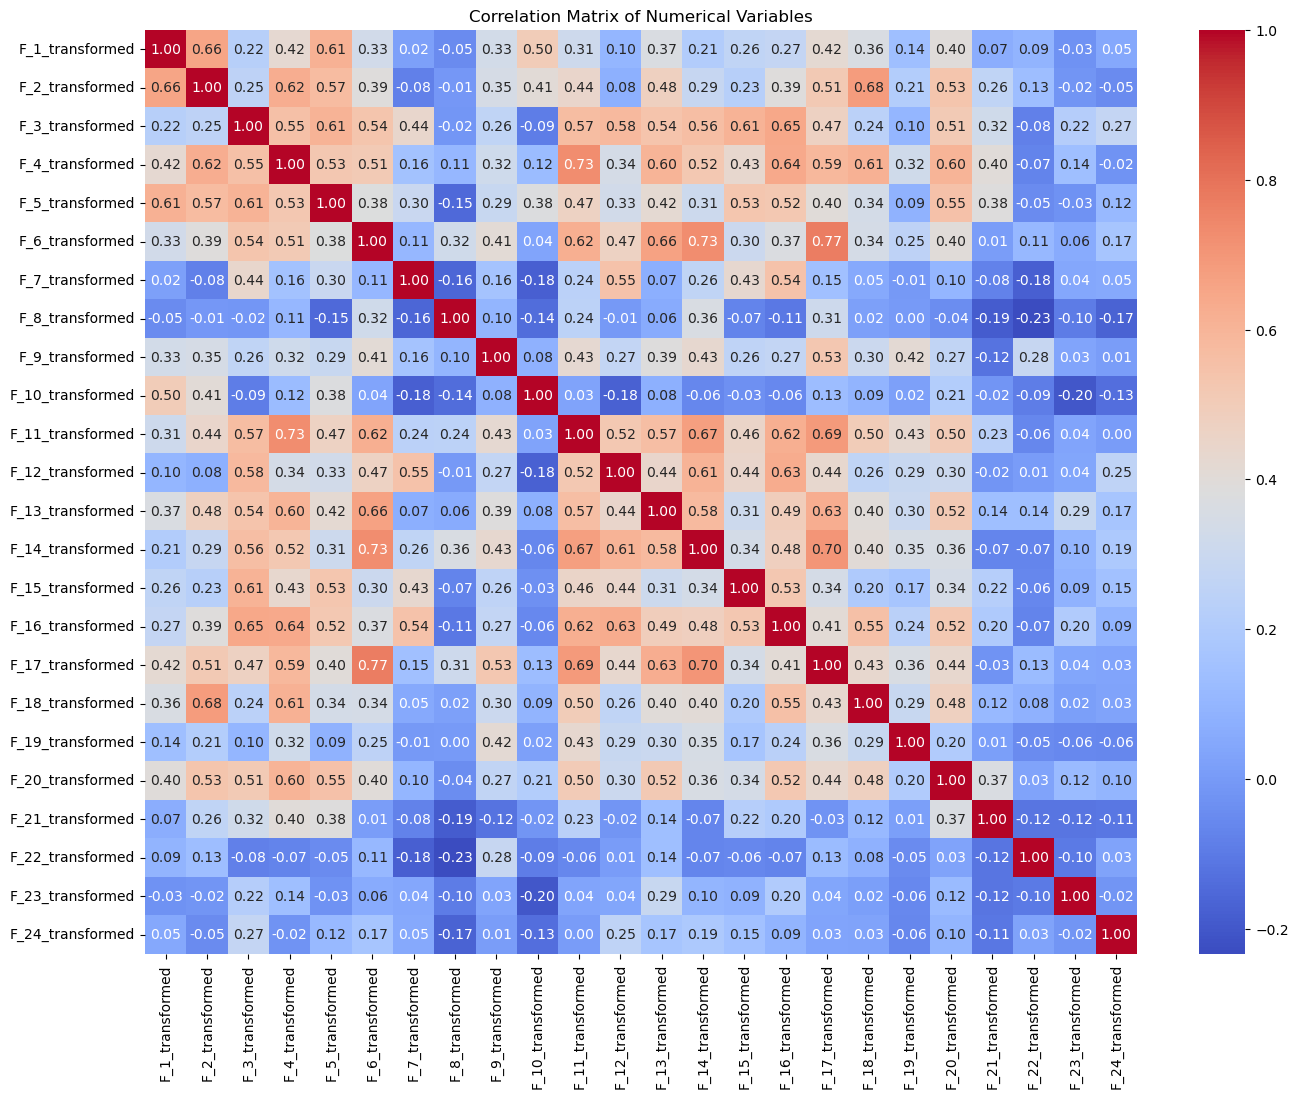

In [15]:
# Select numerical columns
numerical_cols = data_tranformed.columns[data_tranformed.columns.str.contains("_transformed")]
numerical_df = data_tranformed[numerical_cols]
corr_matrix = numerical_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

So, there is some correlation. Especially those 3 pairs with correlation above 0.7: 
* "F_11" and "F_4" 
* "F_6" and "F_14" 
* "F_6" and "F_17"

## PCA

Let's check the PCA of the data to see if there are some patterns. I will use 2D plot and 3D plot.

/var/folders/tf/tzhjhrlj1_x14gcsq_wsn4580000gn/T/ipykernel_81483/4171415551.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis')


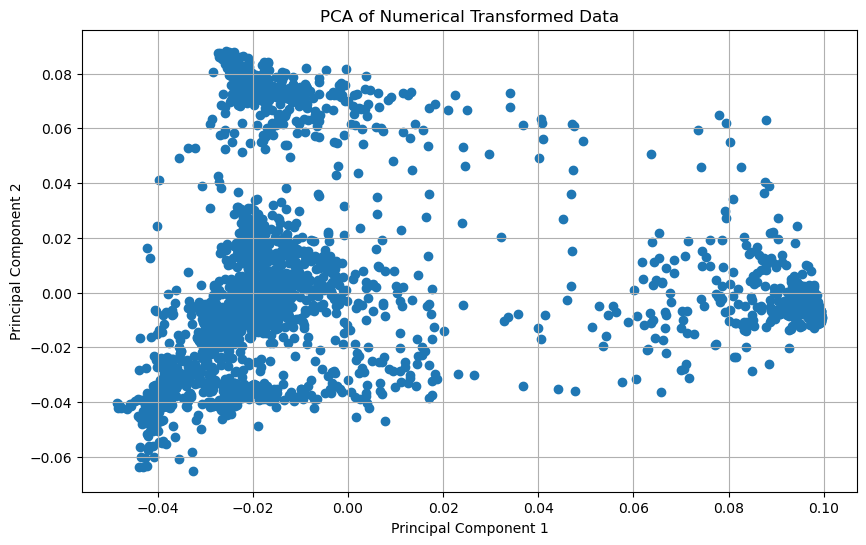

In [16]:
#%% PCA
numerical_cols = data_tranformed.columns.difference(["site"])
numerical_df = data_tranformed[numerical_cols]

pca = PCA(n_components=4) 
principal_components = pca.fit_transform(numerical_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Numerical Transformed Data')
plt.grid(True)
plt.show()

In [17]:
# 3D plot on Transformed Data

numerical_cols = data_tranformed.columns.difference(["site"])
numerical_df = data_tranformed[numerical_cols]

pca = PCA(n_components=4)
principal_components = pca.fit_transform(numerical_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

x_col = 'PC1'
y_col = 'PC2'
z_col = 'PC3'

fig = px.scatter_3d(pca_df, x=x_col, y=y_col, z=z_col, color=z_col,
                    title=f'3D Scatter Plot of {x_col} vs {y_col} vs {z_col}')
fig.update_layout(width=1000, height=800)
fig.show()

Apparently there are some clusters based on the features itself. 

## Clustering

Lets's now check if there are some clusters based on the similarity metrics. I will use KMeans, as a metric I used Silhouette Score and Davies Bouldin Index. I used Elbow Method to find the best number of clusters along with the Silhouette Score and Davies Bouldin Index.
Also, I tried DBSCAN, but for the simplicity, I will stick to KMeans.

In [18]:
clusterer = WordEmbeddingClustering(data_tranformed)
clusterer.cluster_embeddings(
    method='kmeans',
    n_clusters=7
)

evaluation = clusterer.evaluate_clustering()
print("\nClustering Evaluation:")
print(pd.DataFrame(evaluation, index=['value']).T)
print("----"*20)
print(pd.DataFrame.from_dict(evaluation["cluster_silhouette_scores"], orient='index', columns=['silhouette_score']))

labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Number of clusters found: {n_clusters}')


Clustering Evaluation:
                              value
silhouette_score           0.561459
davies_bouldin_index       0.882262
cluster_silhouette_scores       NaN
--------------------------------------------------------------------------------
   silhouette_score
0          0.681295
1          0.617198
2          0.271614
3          0.567465
4          0.607641
5          0.603776
6          0.590967
Number of clusters found: 7


Why I chose 7 clusters?

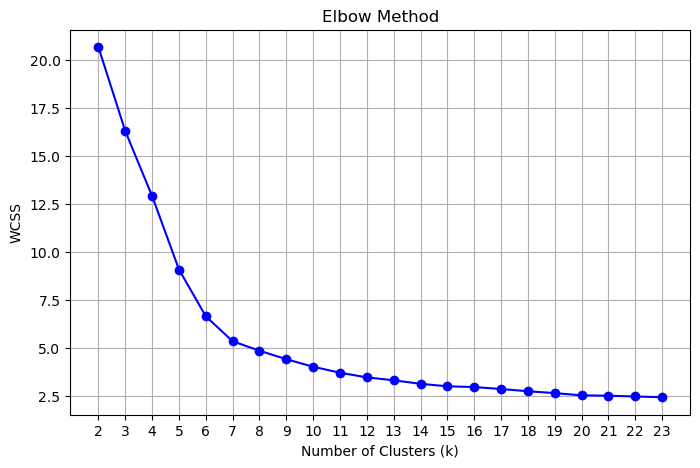

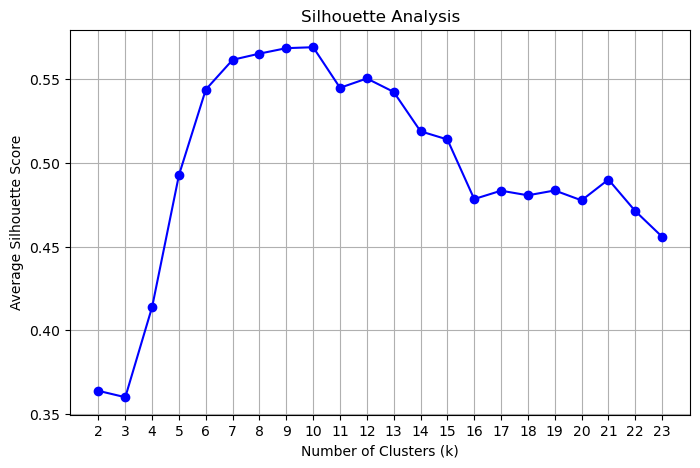

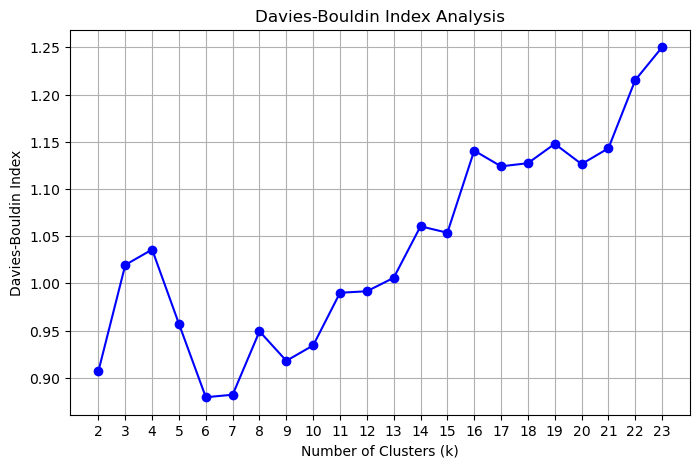

In [19]:
k_range = range(2, 24)

# Find optimal clusters
metrics = clusterer.find_optimal_clusters(k_range)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(metrics['k_values'], metrics['wcss'], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.xticks(metrics['k_values'])
plt.grid(True)
plt.show()

# Plot Silhouette Analysis
plt.figure(figsize=(8, 5))
plt.plot(metrics['k_values'], metrics['silhouette_scores'], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis')
plt.xticks(metrics['k_values'])
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 5))
plt.plot(metrics['k_values'], metrics['davies_bouldin_scores'], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Analysis')
plt.xticks(metrics['k_values'])
plt.grid(True)
plt.show()

What are some websites within the clusters?

In [20]:
pd_webs = []

for i in range(7):
    pd_webs.append(clusterer.labels_series[clusterer.labels_series == i].head(20).index)
pd.DataFrame(pd_webs).T

,0,1,2,3,4,5,6
0,ladysavings.com,legacy.curseforge.com,petcarerx.com,travelandleisure.com,redditmlbstreams.live,login.ufl.edu,signin.att.com
1,belleofthekitchen.com,mapgenie.io,npr.org,costcotravel.com,govx.com,slidesgo.com,citiretailservices.citibankonline.com
2,api.kroger.com,wow-professions.com,forum.chronofhorse.com,rsa.choiceadvantage.com,texassports.com,uc.instructure.com,citizensbank.com
3,sso.compassmanager.com,unrealengine.com,thepetitionsite.com,motel6.com,tsn.ca,nshe-unlv.okta.com,portal.discover.com
4,hy-vee.com,pokemon.com,fark.com,new.mta.info,scorebooklive.com,artofproblemsolving.com,eetd2.adp.com
5,goldbelly.com,kidadl.com,cf.org,rvshare.com,wtatennis.com,uvu.instructure.com,www1.deltadentalins.com
6,juliasalbum.com,1v1.lol,order.preparedhero.com,travelocity.com,watchprowrestling.co,livescience.com,secure05ea.chase.com
7,jerseymikes.com,pokemondb.net,abc7chicago.com,royalcaribbean.com,sherdog.com,canvas.csun.edu,dmsapp.dealercenter.net
8,hotschedules.com,answers.ea.com,leaffilterguards.com,travel.delta.com,methstreams.me,ublearns.buffalo.edu,foragentsonly.com
9,pizzahut.com,dndbeyond.com,discounttire.com,bookings.travelclick.com,forums.rivals.com,lausd.org,signin.travelers.com


However, if I just pick 5 the most similar websites based on the similarity metric, we can get those websites. It seems to me that it depends on the application what you need:

In [21]:
# Provedení analýzy
results = analyze_web_similarity(data_tranformed)
results["similarity_dict"]["wine.com"]

[{'web': 'atlanta.eater.com',
  'cosine_similarity': 0.9999585789841524,
  'euclidean_distance': 0.0010945595980344444,
  'jaccard_sim': 0.9792241085401068},
 {'web': 'bjsrestaurants.com',
  'cosine_similarity': 0.9999523213142252,
  'euclidean_distance': 0.0011743030943220179,
  'jaccard_sim': 0.9790782764865958},
 {'web': 'media-cdn.getbento.com',
  'cosine_similarity': 0.9999199614061511,
  'euclidean_distance': 0.0015214691645959008,
  'jaccard_sim': 0.9725142687963412},
 {'web': 'chicago.eater.com',
  'cosine_similarity': 0.9998948272398008,
  'euclidean_distance': 0.0017442656316078637,
  'jaccard_sim': 0.9646129119591619},
 {'web': 'eatwell101.com',
  'cosine_similarity': 0.9998707287013481,
  'euclidean_distance': 0.0019335684774230964,
  'jaccard_sim': 0.9761093058623447}]

## Discussion
Given your analysis, how do you think that the embedded vectors were calculated, what do you think that each feature represents?

In [22]:
##### -------- answer goes here (add as many cells as you need) --------- ########

To me it seems that you scraped the websites and did embeddings of the content of the websites. Because the embeddings matrix is trained on large corpus of text, the features might be some kind of topics that the website is about. Also, there might be correlations between the features, because the topics are not independent. For example, if the website is about sport, it is likely that it is also about health and sport news as well. 

How many clusters should I pick depends on the application. If I want to find the most similar websites, I should just pick the websites with the highest similarity metric. If I want to reduce the dimensionality I would rather use less dimensional embedding matrix but using PCA we can reduce the number of features. If I want to find the groups of websites with similar topics, I should use clustering. There is no one answer to fit all requirements.